In [85]:
import pandas as pd
import matplotlib.pyplot as plt  # for visualization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
%pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

Note: you may need to restart the kernel to use updated packages.


In [86]:
# read in hardware data to dataframe
hardware_df = pd.read_csv('data/PowerStations_LiFePo4_Dec27_2024.csv')

In [87]:
#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['DoD','Cycles','Unregulated Output','Link','Battery Type','App Control','Bypass Mode','Min PV Voltage','Max PV Voltage','Max AC Input Amps'
                                        , 'Warranty Years','Lifespan','Notes','Real Minimum Grid Charge Efficiency','Estimated Minimum Grid Charge Efficiency'])

retailPriceColumns = ['Retail Price (11/12/2023)','Retail Price (12/30/2023)','Retail Price (1/11/2024)','Retail Price (1/26/2024)','Retail Price (12/27/2024)']

#filter out batteries over specified size
#print(hardware_df[hardware_df['Battery Wh'] > 2000])
#hardware_df = hardware_df[hardware_df['Battery Wh'] <= 2000]

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,AC Charger Watts,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Retail Price (12/27/2024)
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,5.0,300,100.0,2.00,NaN,100.0,85.0,254.0,299.99,299.99,NaN,299.99,NaN
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,11.0,1000,1800.0,1.75,NaN,NaN,85.0,399.0,799.00,799.00,NaN,799.00,NaN
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,22.0,2000,1800.0,1.70,NaN,NaN,85.0,899.0,1199.00,1199.00,NaN,1199.00,NaN
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,24.0,3000,1800.0,2.00,NaN,NaN,85.0,1659.0,2199.00,2199.00,NaN,2199.00,NaN
4,Pecron,E600LFP,614.00,400,0.651466,7.0,1200,NaN,2.20,NaN,NaN,85.0,299.0,499.00,299.00,NaN,329.00,NaN


In [88]:
#get average retail prices
hardware_df['avg retail price']= hardware_df[retailPriceColumns].mean(axis=1)
hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,AC Charger Watts,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Retail Price (12/27/2024),avg retail price
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,5.0,300,100.0,2.00,NaN,100.0,85.0,254.0,299.99,299.99,NaN,299.99,NaN,284.660000
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,11.0,1000,1800.0,1.75,NaN,NaN,85.0,399.0,799.00,799.00,NaN,799.00,NaN,665.666667
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,22.0,2000,1800.0,1.70,NaN,NaN,85.0,899.0,1199.00,1199.00,NaN,1199.00,NaN,1099.000000
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,24.0,3000,1800.0,2.00,NaN,NaN,85.0,1659.0,2199.00,2199.00,NaN,2199.00,NaN,2019.000000
4,Pecron,E600LFP,614.00,400,0.651466,7.0,1200,NaN,2.20,NaN,NaN,85.0,299.0,499.00,299.00,NaN,329.00,NaN,309.000000


In [100]:
#display(hardware_df.tail())

#get average charge time percent for 80% relative to a 100% charge
hardware_df['charge ratio']= hardware_df['80 Per Grid Charge Hours']/hardware_df['Full Grid Charge Hours']

#display(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'])
#get the average ratio of 80% to 100% 
eightyCT = round(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'].mean()*100,2)*.01
print(str(eightyCT*100) + '% of the full charge time is spent charging from 0-80%.')
# #display(hardware_df.tail())

#update full charge column
hardware_df['Full Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] = hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] / eightyCT

#update 80% charge column
hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] = hardware_df['Full Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] * eightyCT

display(hardware_df.tail())

59.70000000000001% of the full charge time is spent charging from 0-80%.


C:\Users\Alex\AppData\Local\Temp\ipykernel_592\230361453.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hardware_df['Full Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] = hardware_df['80 Per Grid Charge Hours']

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,AC Charger Watts,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Retail Price (12/27/2024),avg retail price,charge ratio
65,OUKITEL,CN505,615.0,100,0.162602,3.0,500,NaN,7.000000,4.179000,90.0,88.0,269.0,599.0,NaN,NaN,NaN,NaN,269.0,0.597000
66,OUKITEL,P1201,960.0,500,0.520833,15.0,1200,700.0,2.512563,1.500000,NaN,80.0,499.0,799.0,439.0,NaN,439.0,NaN,459.0,0.597000
67,OUKITEL,P2001,2000.0,500,0.250000,15.0,2000,1100.0,3.015075,1.800000,NaN,80.0,899.0,1299.0,899.0,NaN,899.0,NaN,899.0,0.597000
68,OUKITEL,BP2000,2048.0,1000,0.488281,15.0,2200,1800.0,2.512563,1.500000,NaN,80.0,NaN,NaN,NaN,1699.0,1699.0,NaN,1699.0,0.597000
69,Zendure,SuperBase Pro Power Station 1500,1440.0,600,0.416667,10.0,2000,1800.0,2.000000,1.066667,NaN,80.0,NaN,NaN,NaN,NaN,1699.0,NaN,1699.0,0.533333


In [101]:
#if inverter efficiency data isn't available use minimum value
defaultInverterEfficiency = min(hardware_df['Inverter Efficiency'])

hardware_df['Inverter Efficiency'] = hardware_df['Inverter Efficiency'].fillna(defaultInverterEfficiency)

In [102]:
hardware_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Make                       70 non-null     object 
 1   Model                      70 non-null     object 
 2   Battery Wh                 70 non-null     float64
 3   Max PV Watts               70 non-null     int64  
 4   W to Wh Ratio              70 non-null     float64
 5   Max PV Amps                40 non-null     float64
 6   Inverter Watts             70 non-null     int64  
 7   Max AC Input Watts         37 non-null     float64
 8   Full Grid Charge Hours     70 non-null     float64
 9   80 Per Grid Charge Hours   70 non-null     float64
 10  AC Charger Watts           30 non-null     float64
 11  Inverter Efficiency        70 non-null     float64
 12  Retail Price (11/12/2023)  50 non-null     float64
 13  Full Price (11/20/2023)    50 non-null     float64
 

In [103]:
#drop columns with significant missing data
cleaned_df = hardware_df.drop(columns=['Make','Model','Max PV Amps','Max AC Input Watts','AC Charger Watts','charge ratio','Full Grid Charge Hours','Retail Price (12/27/2024)','Retail Price (1/26/2024)','Retail Price (1/11/2024)','Retail Price (12/30/2023)','Full Price (11/20/2023)','Retail Price (11/12/2023)'])

In [104]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Battery Wh                70 non-null     float64
 1   Max PV Watts              70 non-null     int64  
 2   W to Wh Ratio             70 non-null     float64
 3   Inverter Watts            70 non-null     int64  
 4   80 Per Grid Charge Hours  70 non-null     float64
 5   Inverter Efficiency       70 non-null     float64
 6   avg retail price          70 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 4.0 KB


In [105]:
cleaned_df.describe()

,Battery Wh,Max PV Watts,W to Wh Ratio,Inverter Watts,80 Per Grid Charge Hours,Inverter Efficiency,avg retail price
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,1188.327143,501.142857,0.417758,1410.428571,1.737940,86.657143,880.604000
std,670.898288,397.410250,0.193039,769.474573,1.190829,4.643480,535.626436
min,99.900000,40.000000,0.129199,150.000000,0.597000,80.000000,149.000000
25%,599.900000,200.000000,0.275876,625.000000,0.895500,85.000000,456.500000
50%,1210.000000,425.000000,0.393725,1350.000000,1.194000,87.000000,832.333333
75%,1596.000000,775.000000,0.494279,2000.000000,2.358150,90.000000,1237.375000
max,2560.000000,2100.000000,1.025391,3000.000000,4.776000,96.000000,2299.000000


## Encode

In [106]:
# none

## Cluster

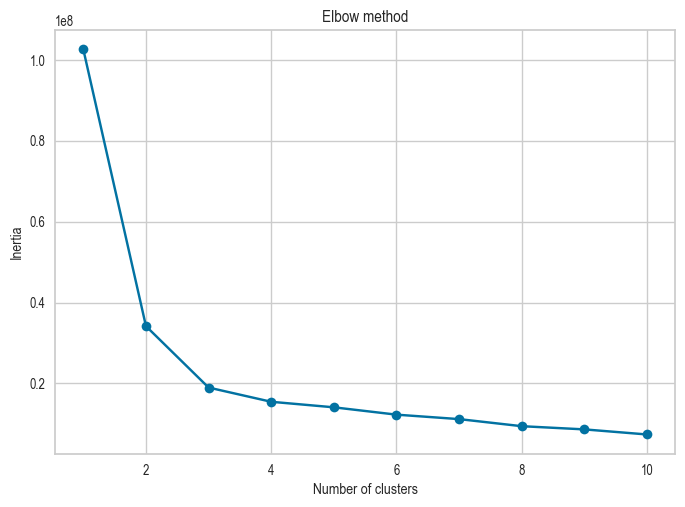

In [107]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cleaned_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [99]:
#get avg silhouette scores
for i in range(2,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cleaned_df)
    kmeans.labels_
    score = silhouette_score(cleaned_df, kmeans.labels_, metric='euclidean')
    print('For ' + str(i) + ' clusters, the average silhoutte score is ' + str(score))

For 2 clusters, the average silhoutte score is 0.5293229908754673
For 3 clusters, the average silhoutte score is 0.47850565958808206
For 4 clusters, the average silhoutte score is 0.41177433737614183
For 5 clusters, the average silhoutte score is 0.3244934685708532
For 6 clusters, the average silhoutte score is 0.30066036993170664
For 7 clusters, the average silhoutte score is 0.2961529037174729
For 8 clusters, the average silhoutte score is 0.3037449282042443
For 9 clusters, the average silhoutte score is 0.3067710025335577
For 10 clusters, the average silhoutte score is 0.3355616086061352
For 11 clusters, the average silhoutte score is 0.33010587238553296
For 12 clusters, the average silhoutte score is 0.22411144837652383
For 13 clusters, the average silhoutte score is 0.3084576045530383
For 14 clusters, the average silhoutte score is 0.3146202654897529
For 15 clusters, the average silhoutte score is 0.32121598521790995
For 16 clusters, the average silhoutte score is 0.31544346122802

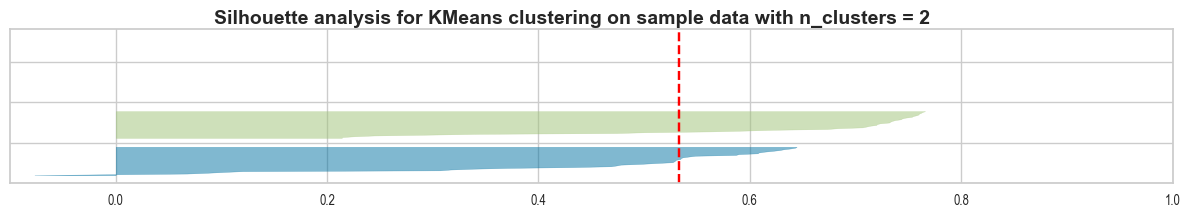

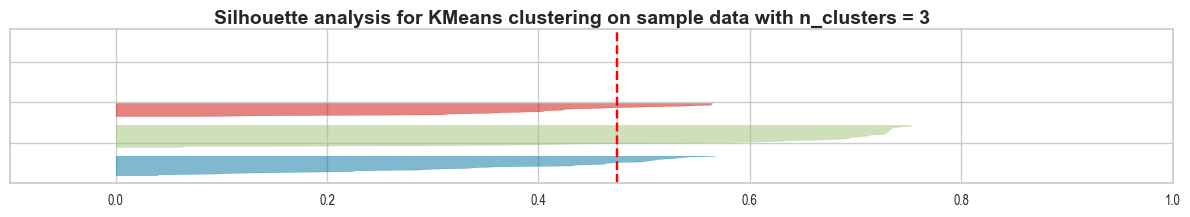

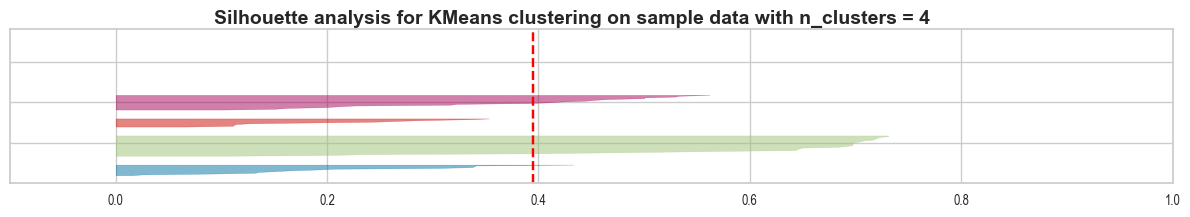

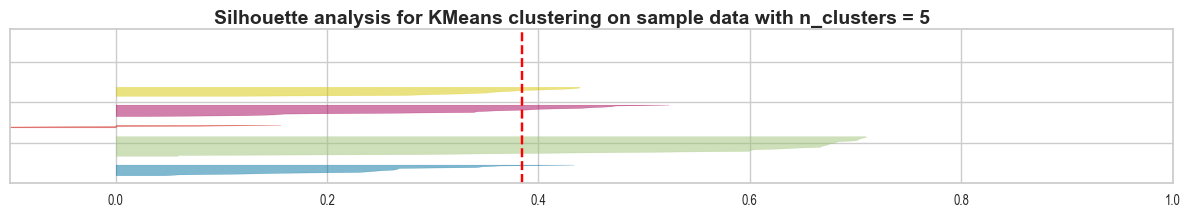

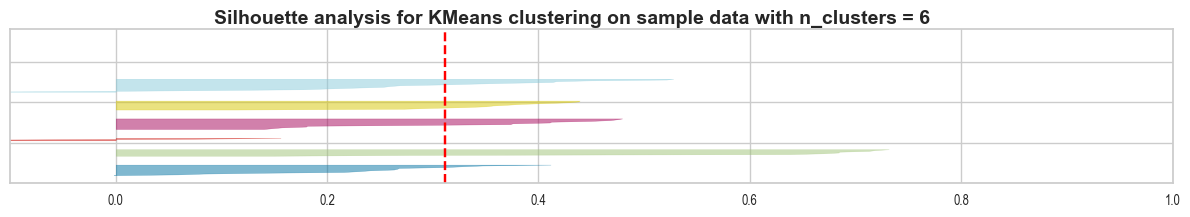

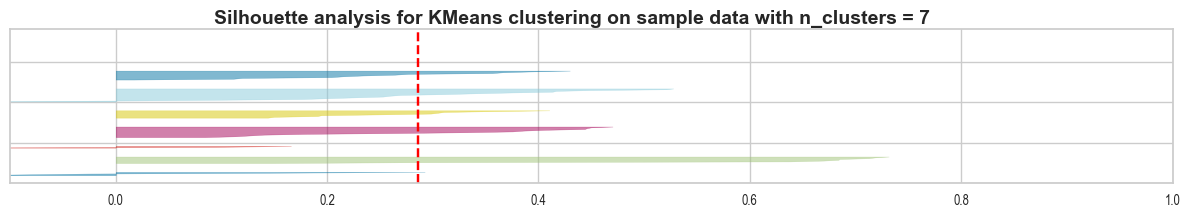

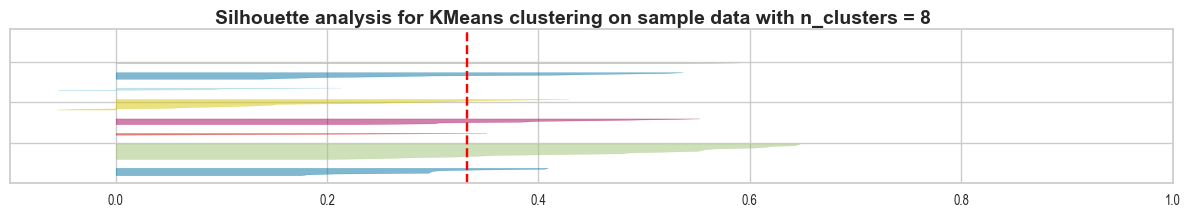

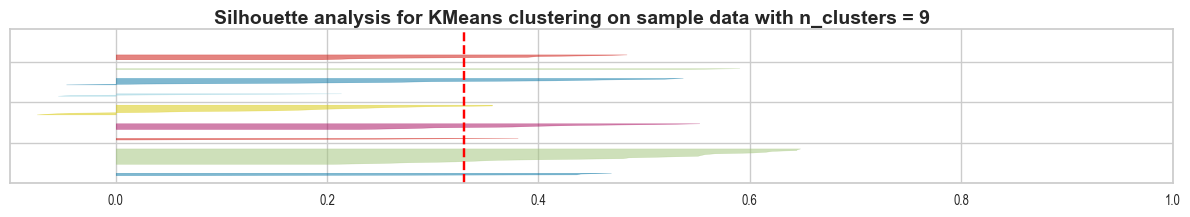

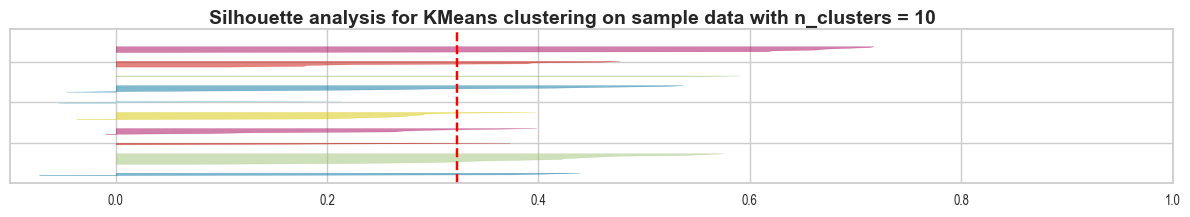

In [98]:
for s in range(2,11):
    fig, ax1 = plt.subplots(figsize=(15, 2))#plt.figure(figsize=(15, 3), layout='constrained')
    #plt.figure(figsize = (15,3)) 
    plt.tick_params(left = False, right = False , labelleft = False) 
    kmeans = KMeans(n_clusters=s, random_state=10)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cleaned_df) + (11 + 1) * 10])
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick',ax=ax1)
    visualizer.fit(cleaned_df)        # Fit the data to the visualizer

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % s,
        fontsize=14,
        fontweight="bold",
    )
    plt.show()        # Finalize and render the figure


In [208]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(cleaned_df)

print(kmeans.labels_)

[2 0 3 1 2 3 1 0 3 1 2 2 2 2 2 2 2 2 2 2 0 3 0 3 1 1 1 1 1 0 1 2 2 2 0 1 0
 1 3 0 3 1 2 0 3 1 1 2 2 2 2 2 0 3 0 0 1 2 2 0 0 3 3 3 2 2 0 3 1 3]


In [209]:
clustered_df = cleaned_df
clustered_df['Make'] =  hardware_df['Make']
clustered_df['Model'] =  hardware_df['Model']
clustered_df['labels'] = kmeans.labels_

clustered_df.head()

,Battery Wh,Max PV Watts,W to Wh Ratio,Inverter Watts,80 Per Grid Charge Hours,Inverter Efficiency,avg retail price,Make,Model,labels
0,288.00,100,0.347222,300,1.19400,85.0,284.660000,Jackery,Explorer 300 Plus,2
1,680.96,600,0.881109,1000,1.04475,85.0,665.666667,Jackery,Explorer 700 Plus,0
2,1264.64,800,0.632591,2000,1.01490,85.0,1099.000000,Jackery,Explorer 1000 Plus,3
3,2042.80,1400,0.685334,3000,1.19400,85.0,2019.000000,Jackery,Explorer 2000 Plus,1
4,614.00,400,0.651466,1200,1.31340,85.0,309.000000,Pecron,E600LFP,2


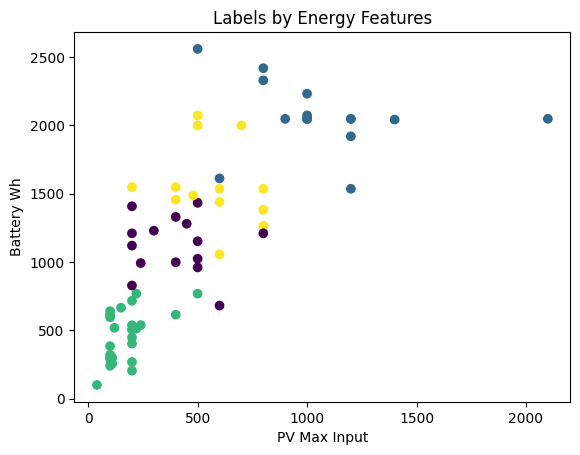

In [210]:
plt.scatter(clustered_df['Max PV Watts'],clustered_df['Battery Wh'], c=clustered_df['labels'])
plt.title('Labels by Energy Features')
plt.xlabel('PV Max Input')
plt.ylabel('Battery Wh')
plt.show() 

In [211]:
bluetti_df = clustered_df[clustered_df['Make']=='Bluetti'].drop(columns=['labels'])
bluetti_df

,Battery Wh,Max PV Watts,W to Wh Ratio,Inverter Watts,80 Per Grid Charge Hours,Inverter Efficiency,avg retail price,Make,Model
12,268.0,200,0.746269,600,0.8955,90.0,209.000000,Bluetti,EB3A
13,537.0,200,0.372439,700,1.7910,90.0,374.000000,Bluetti,EB55
14,716.0,200,0.279330,800,2.3880,90.0,472.333333,Bluetti,EB70S
15,204.0,200,0.980392,300,0.7164,80.0,159.000000,Bluetti,AC2A
16,448.0,200,0.446429,700,0.7500,80.0,299.000000,Bluetti,AC50B
17,403.0,200,0.496278,600,0.5970,90.0,624.000000,Bluetti,AC60
18,504.0,200,0.396825,600,0.5970,90.0,715.666667,Bluetti,AC60P
19,768.0,500,0.651042,1000,0.9552,80.0,379.000000,Bluetti,AC70
20,1152.0,500,0.434028,1800,0.7500,90.0,649.000000,Bluetti,AC180
21,1440.0,500,0.347222,1800,0.7500,90.0,1032.333333,Bluetti,AC180P


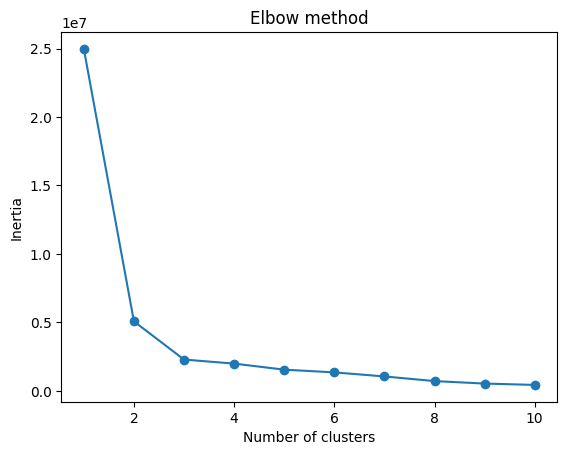

In [212]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(bluetti_df.drop(columns=['Make','Model']) )
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [213]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(bluetti_df.drop(columns=['Make','Model']))

print(kmeans.labels_)
bluetti_df['labels']=kmeans.labels_

[0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1]


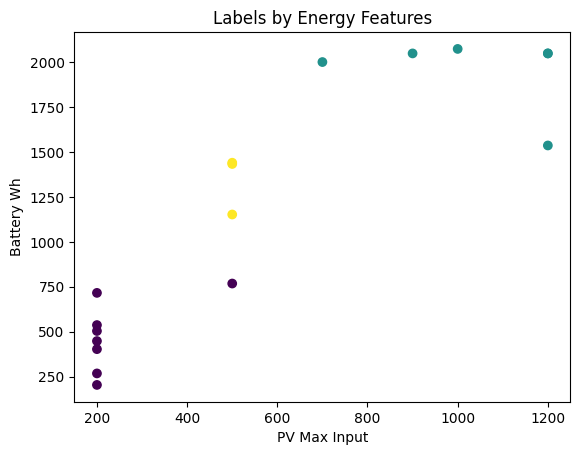

In [214]:
plt.scatter(bluetti_df['Max PV Watts'],bluetti_df['Battery Wh'], c=bluetti_df['labels'])
plt.title('Labels by Energy Features')
plt.xlabel('PV Max Input')
plt.ylabel('Battery Wh')
plt.show() 

In [215]:
bluetti_df

,Battery Wh,Max PV Watts,W to Wh Ratio,Inverter Watts,80 Per Grid Charge Hours,Inverter Efficiency,avg retail price,Make,Model,labels
12,268.0,200,0.746269,600,0.8955,90.0,209.000000,Bluetti,EB3A,0
13,537.0,200,0.372439,700,1.7910,90.0,374.000000,Bluetti,EB55,0
14,716.0,200,0.279330,800,2.3880,90.0,472.333333,Bluetti,EB70S,0
15,204.0,200,0.980392,300,0.7164,80.0,159.000000,Bluetti,AC2A,0
16,448.0,200,0.446429,700,0.7500,80.0,299.000000,Bluetti,AC50B,0
17,403.0,200,0.496278,600,0.5970,90.0,624.000000,Bluetti,AC60,0
18,504.0,200,0.396825,600,0.5970,90.0,715.666667,Bluetti,AC60P,0
19,768.0,500,0.651042,1000,0.9552,80.0,379.000000,Bluetti,AC70,0
20,1152.0,500,0.434028,1800,0.7500,90.0,649.000000,Bluetti,AC180,2
21,1440.0,500,0.347222,1800,0.7500,90.0,1032.333333,Bluetti,AC180P,2
